In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Dataset paths
pannuke_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/PanNuke")
fold2_path = pannuke_path / "Fold 2"

# Load images, types, and masks
images_npy = fold2_path / "images/fold2/images.npy"
types_npy = fold2_path / "images/fold2/types.npy"
masks_npy = fold2_path / "masks/fold2/masks.npy"

print("📥 Loading PanNuke Fold 2 data...")
images = np.load(images_npy, mmap_mode='r')  # Memory-mapped for efficiency
types = np.load(types_npy)
masks = np.load(masks_npy, mmap_mode='r')

print(f"\n✅ Loaded successfully!")
print(f"  Images shape: {images.shape} - dtype: {images.dtype}")
print(f"  Types shape: {types.shape} - dtype: {types.dtype}")
print(f"  Masks shape: {masks.shape} - dtype: {masks.dtype}")

# Check unique tissue types
unique_types = np.unique(types)
print(f"\n🔬 Unique tissue types ({len(unique_types)}):")
for tissue_type in unique_types[:5]:  # First 5
    count = np.sum(types == tissue_type)
    print(f"  - {tissue_type}: {count} images")
print(f"  ... and {len(unique_types) - 5} more")

# Check mask channels (should be 6: 5 cell types + background)
print(f"\n🎭 Mask channels: {masks.shape[-1]}")
print("  Channel mapping:")
print("    0: Neoplastic cells")
print("    1: Inflammatory") 
print("    2: Connective/Soft tissue")
print("    3: Dead cells")
print("    4: Epithelial")
print("    5: Background")

print(f"\n📌 Value ranges:")
print(f"  Images: [{images.min():.3f}, {images.max():.3f}]")
print(f"  Masks: [{masks.min()}, {masks.max()}]")

📥 Loading PanNuke Fold 2 data...

✅ Loaded successfully!
  Images shape: (2523, 256, 256, 3) - dtype: float64
  Types shape: (2523,) - dtype: <U13
  Masks shape: (2523, 256, 256, 6) - dtype: float64

🔬 Unique tissue types (19):
  - Adrenal_gland: 148 images
  - Bile-duct: 103 images
  - Bladder: 61 images
  - Breast: 749 images
  - Cervix: 52 images
  ... and 14 more

🎭 Mask channels: 6
  Channel mapping:
    0: Neoplastic cells
    1: Inflammatory
    2: Connective/Soft tissue
    3: Dead cells
    4: Epithelial
    5: Background

📌 Value ranges:
  Images: [0.000, 255.000]
  Masks: [0.0, 3515.0]


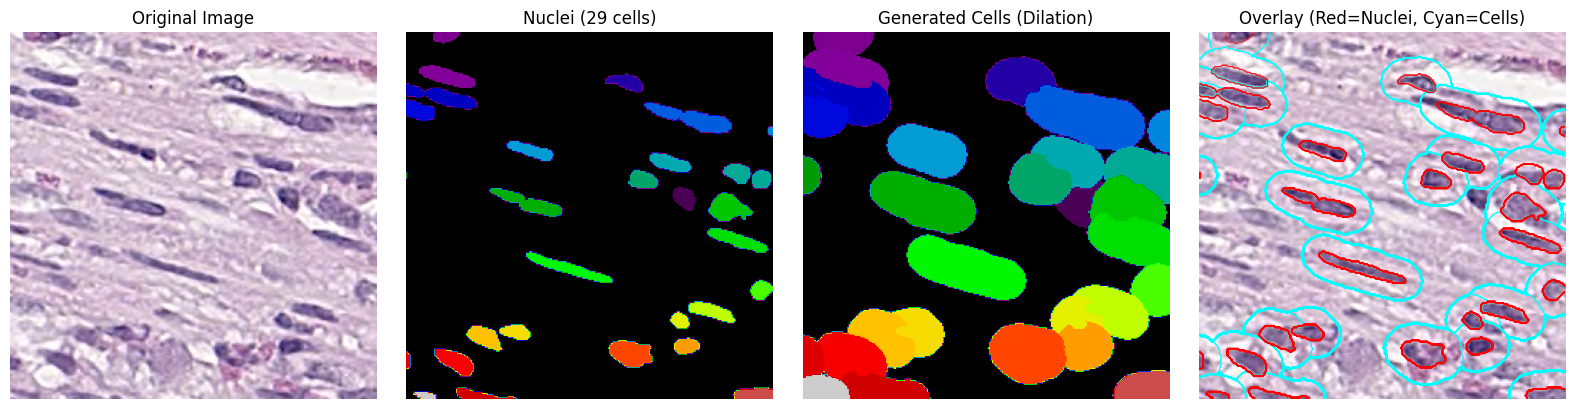

✅ Sample 1863 | Tissue: HeadNeck | Nuclei: 29


In [24]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from skimage.measure import regionprops, label
from skimage.morphology import binary_dilation, disk

# Pick one random sample
idx = np.random.randint(0, len(images))
img = images[idx].astype(np.uint8)
mask = masks[idx]

# Combine all nucleus channels into single instance mask
nuclei_mask = np.zeros((256, 256), dtype=np.int32)
instance_id = 1
for channel in range(5):
    channel_mask = mask[:, :, channel]
    labeled = label(channel_mask > 0)
    for region_id in np.unique(labeled)[1:]:
        nuclei_mask[labeled == region_id] = instance_id
        instance_id += 1

# NEW APPROACH: Dilate nuclei by fixed amount (like real cytoplasm)
cell_mask = np.zeros_like(nuclei_mask)
for nuc_id in np.unique(nuclei_mask)[1:]:
    nucleus = (nuclei_mask == nuc_id)
    # Dilate each nucleus by ~10-15 pixels (typical cytoplasm size)
    cell = binary_dilation(nucleus, disk(12))
    cell_mask[cell] = nuc_id

# Handle overlaps - keep original nucleus owner
cell_mask[nuclei_mask > 0] = nuclei_mask[nuclei_mask > 0]

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(nuclei_mask, cmap='nipy_spectral')
axes[1].set_title(f'Nuclei ({instance_id-1} cells)')
axes[1].axis('off')

axes[2].imshow(cell_mask, cmap='nipy_spectral')
axes[2].set_title('Generated Cells (Dilation)')
axes[2].axis('off')

axes[3].imshow(img)
axes[3].contour(cell_mask, levels=np.unique(cell_mask)[1:], colors='cyan', linewidths=1)
axes[3].contour(nuclei_mask, levels=np.unique(nuclei_mask)[1:], colors='red', linewidths=0.5)
axes[3].set_title('Overlay (Red=Nuclei, Cyan=Cells)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Sample {idx} | Tissue: {types[idx]} | Nuclei: {instance_id-1}")